# Emulator: Celerite

This notebook provides a template to build an emulator with [Celerite](https://celerite.readthedocs.io/en/stable/). If you want to use the emulators on the emulator class, refer to [].

#### Index<a name="index"></a>
1. [Import packages](#imports)
* [Load data](#loadData)
 1. [Load train data](#loadTrainData)
 * [Load test data](#loadTestData)
* [Emulator method](#emulator)

## 1. Import packages<a name="imports"></a>


In [1]:
import numpy as np
import pickle

import matplotlib.pyplot as plt
import matplotlib
from matplotlib import pylab
%config InlineBackend.figure_format = 'retina'
matplotlib.rcParams['figure.dpi'] = 80
textsize = 'x-large'
params = {'legend.fontsize': 'large',
          'figure.figsize': (5, 4),
         'axes.labelsize': textsize,
         'axes.titlesize': textsize,
         'xtick.labelsize': textsize,
         'ytick.labelsize': textsize}
pylab.rcParams.update(params)

from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler

from scipy.optimize import minimize

import celerite
from celerite import terms

## 2. Load data<a name="loadData"></a>

Read the training data from a `.npy` file:

### 2.1. Load training data<a name="loadTrainData"></a>

In [68]:
path_train = '../data/cosmology_train_big.pickle'

with open(path_train, 'rb') as input_file:
    data_train = pickle.load(input_file)

In [4]:
data_train

{'input_data':      object_id  $\Omega_m$  $\sigma_8$  $\Omega_b$
 0        obj_0    0.260000        0.70    0.038000
 1        obj_1    0.260000        0.70    0.039053
 2        obj_2    0.260000        0.70    0.040105
 3        obj_3    0.260000        0.70    0.041158
 4        obj_4    0.260000        0.70    0.042211
 5        obj_5    0.260000        0.70    0.043263
 6        obj_6    0.260000        0.70    0.044316
 7        obj_7    0.260000        0.70    0.045368
 8        obj_8    0.260000        0.70    0.046421
 9        obj_9    0.260000        0.70    0.047474
 10      obj_10    0.260000        0.70    0.048526
 11      obj_11    0.260000        0.70    0.049579
 12      obj_12    0.260000        0.70    0.050632
 13      obj_13    0.260000        0.70    0.051684
 14      obj_14    0.260000        0.70    0.052737
 15      obj_15    0.260000        0.70    0.053789
 16      obj_16    0.260000        0.70    0.054842
 17      obj_17    0.260000        0.70    0.05589

In [69]:
input_train = data_train['input_data']
number_train = input_train.shape[0]
print("Number of datapoints:", number_train)

Number of datapoints: 8000


In [70]:
output_train = data_train['output_data']
n_params = input_train.shape[1]-1
n_values = output_train.shape[1]-1
print("Number of input parameters:", n_params)  # remove the `object_id` column
print("Number of output values:", n_values)  # remove the `object_id` column

Number of input parameters: 3
Number of output values: 10


In [71]:
xs_train = np.array(input_train.drop(columns=['object_id']))
ys_train = np.array(output_train.drop(columns=['object_id']))
extra_train = data_train['extra_input']
r_vals = extra_train['r_vals']

In [21]:
xs_train.shape

(8000, 3)

In [22]:
ys_train.shape

(8000, 10)

In [34]:
# Input data
omega_m  = xs_train[:,0]
sigma_8  = xs_train[:,1]
omega_b  = xs_train[:,2]


# Output data Epsilon(r_i)
epsilon_r0  = ys_train[:,0]
epsilon_r1  = ys_train[:,1]
epsilon_r2  = ys_train[:,2]
epsilon_r3  = ys_train[:,3]
epsilon_r4  = ys_train[:,4]
epsilon_r5  = ys_train[:,5]
epsilon_r6  = ys_train[:,6]
epsilon_r7  = ys_train[:,7]
epsilon_r8  = ys_train[:,8]
epsilon_r9  = ys_train[:,9]

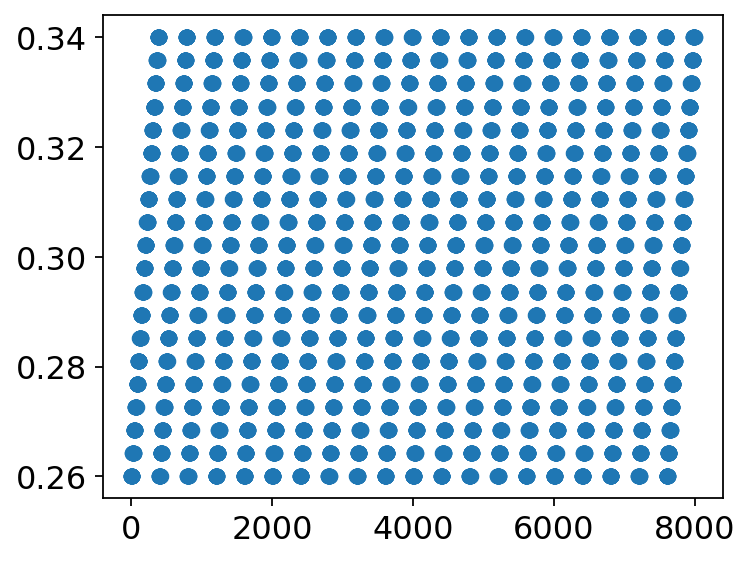

In [36]:
# What we are fitting
plt.plot(omega_m, 'o')

### 2.2. Load test data<a name="loadTrainData"></a> 

In [39]:
path_test = '../data/cosmology_test.pickle'

with open(path_test, 'rb') as input:
    data_test = pickle.load(input)
input_test = data_test['input_data']
number_test = input_test.shape[0]
print("Number of datapoints:", number_test)
output_test = data_test['output_data']
print("Number of input parameters:", input_test.shape[1]-1)  # remove the `object_id` column
print("Number of output values:", output_test.shape[1]-1)  # remove the `object_id` column

Number of datapoints: 100
Number of input parameters: 3
Number of output values: 10


In [40]:
xs_test = np.array(input_test.drop(columns=['object_id']))
ys_test = np.array(output_test.drop(columns=['object_id']))

## 3. Emulator method<a name="emulator"></a>

Let's first scale our input parameters, to make training easier:

In [72]:
scaler = StandardScaler()
scaler.fit(xs_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [73]:
xs_train = scaler.transform(xs_train)
xs_test = scaler.transform(xs_test)

We will use `scikit-learn`'s `MLPRegressor` to build our emulator. We train a separate regressor for each output value. We have to tune the hyperparameters carefully.

In [79]:
x = np.array([xs_train[:,0], xs_train[:,1], xs_train[:,2]]).T
y = ys_train[:,0]

print(x)

# need 2d kernel 
kernel = terms.RealTerm(log_a=np.log(np.var(y)), log_c=-np.log(10.0))

gp = celerite.GP(kernel, mean=0, fit_mean=False)
gp.compute(x)

[[-1.64750894 -1.64750894 -1.64750894]
 [-1.64750894 -1.64750894 -1.47408695]
 [-1.64750894 -1.64750894 -1.30066495]
 ...
 [ 1.64750894  1.64750894  1.30066495]
 [ 1.64750894  1.64750894  1.47408695]
 [ 1.64750894  1.64750894  1.64750894]]


ValueError: the input coordinates must be sorted

In [75]:
# Set up the GP model

# x = np.linspace(0,100,20)
# y = np.random.rand(20)
# yerr = .5*np.random.rand(20)

# x = xs_train

x = np.array([xs_train[:,0], xs_train[:,1], xs_train[:,2]]).T
y = ys_train[:,0]

print(x)

# need 2d kernel 
# kernel = terms.RealTerm(log_a=np.log(np.var(y)), log_c=-np.log(10.0))
kernel = terms.RealTerm(log_a=np.log(np.var(y)), log_c=-np.log(10.0))
# print(kernel.shape)
gp = celerite.GP(kernel, mean=0, fit_mean=False)
gp.compute(x)
print("Initial log-likelihood: {0}".format(gp.log_likelihood(y)))

# Define a cost function
def neg_log_like(params, y, gp):b
    gp.set_parameter_vector(params)
    return -gp.log_likelihood(y)

def grad_neg_log_like(params, y, gp):
    gp.set_parameter_vector(params)
    return -gp.grad_log_likelihood(y)[1]

# Fit for the maximum likelihood parameters
initial_params = gp.get_parameter_vector()
bounds = gp.get_parameter_bounds()
soln = minimize(neg_log_like, initial_params, jac=grad_neg_log_like, args=(y, gp))
gp.set_parameter_vector(soln.x)
print("Final log-likelihood: {0}".format(-soln.fun))

# Make the maximum likelihood prediction
t = np.linspace(-5, 120, 100)
mu, var = gp.predict(y, t, return_var=True)
std = np.sqrt(var)

# # Plot the data
# color = "#ff7f0e"
# plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
# plt.plot(t, mu, color=color)
# plt.fill_between(t, mu+std, mu-std, color=color, alpha=0.3, edgecolor="none")
# plt.ylabel(r"$y$")
# plt.xlabel(r"$x$")
# plt.gca().yaxis.set_major_locator(plt.MaxNLocator(5))
# plt.title("maximum likelihood prediction");


IndentationError: unexpected indent (<ipython-input-75-a9d4aa2f33e1>, line 24)

In [64]:
X = np.array([[-8.0,-8.0], [-6.0,-3.0], [-7.0,2.0], [-4.0,4.0], 
             [2.0,3.0], [5.0,7.0], [1.0,-1.0], [3.0,-4.0], [7.0,-7.0]])

Y = np.array([-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 1.0, 1.0, 1.0])

X_dim1 = X.shape[0]

sigma_f = 1.0

l1 = 4.0
l2 = 4.0

X = X[:,:,np.newaxis]

D = np.zeros((X_dim1,X_dim1))

K = np.zeros((X_dim1,X_dim1))

X1 = X[:,0,:]

D1 = (X1 - X1.T)**2 / (2.0 * l1**2 )

X2 = X[:,1,:]

D2 = (X2 - X2.T)**2 / (2.0 * l2**2 )

K = sigma_f**2*np.exp(-(D1+D2))

K.shape

(9, 9)

In [54]:
regrs = np.empty(n_values, dtype=object)
for j in range(n_values):
    ys_train_r = ys_train[:,j]
    ys_test_r = ys_test[:,j]
    print(xs_train.shape)
    print(ys_train_r.shape)
    if n_params<=1:
        regr = MLPRegressor(hidden_layer_sizes=(14, ), alpha=0.00028, activation='relu',
                        random_state=1, max_iter=10000, solver='lbfgs', tol=1e-6
                       ).fit(xs_train, ys_train_r)
    else:
        regr = MLPRegressor(hidden_layer_sizes=(6, ), alpha=0.001, learning_rate_init=0.08, activation='relu',
                            beta_1=0.9, beta_2=0.995,
                            random_state=1, max_iter=10000, solver='adam', tol=1e-6
                        ).fit(xs_train, ys_train_r)
    score = regr.score(xs_test, ys_test_r)
    print(f"Value {j} score:", score)
    regrs[j] = regr

(8000, 3)
(8000,)
Value 0 score: 0.9384672281943383
(8000, 3)
(8000,)
Value 1 score: 0.9309224073131458
(8000, 3)
(8000,)
Value 2 score: 0.8826043937644035
(8000, 3)
(8000,)
Value 3 score: 0.8437680289818997
(8000, 3)
(8000,)
Value 4 score: 0.8130578348580874
(8000, 3)
(8000,)
Value 5 score: 0.7962791917314085
(8000, 3)
(8000,)
Value 6 score: 0.7216201668150853
(8000, 3)
(8000,)
Value 7 score: -0.1921908210927037
(8000, 3)
(8000,)
Value 8 score: -11.946438068561525
(8000, 3)
(8000,)
Value 9 score: -23.263413985171457


In [47]:
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
X, y = make_regression(n_samples=200, random_state=1)
print(X.shape, y.shape)
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=1)
regr = MLPRegressor(random_state=1, max_iter=500).fit(X_train, y_train)

(200, 100) (200,)


/Users/yssavo/miniconda2/envs/tardis/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Now we can predict on our test dataset

In [14]:
ys_predict = np.zeros((number_test, n_values))
for j in range(n_values):  
    ys_predict_r = regrs[j].predict(xs_test)
    ys_predict[:,j] = ys_predict_r

In [15]:
n_plot = int(0.2*number_test)
idxs = np.random.choice(np.arange(number_test), n_plot)
color_idx = np.linspace(0, 1, n_plot)
colors = np.array([plt.cm.rainbow(c) for c in color_idx])

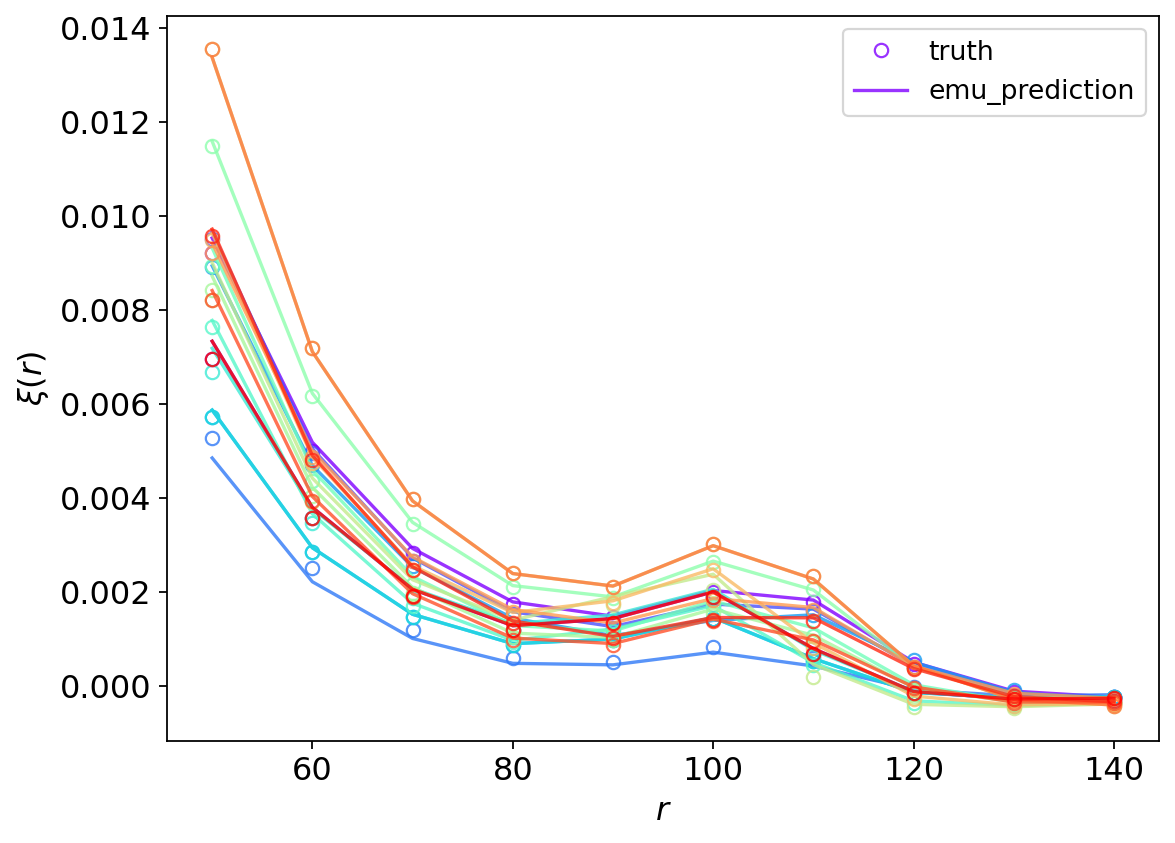

In [16]:
plt.figure(figsize=(8,6))
for i in range(n_plot):
    ys_test_plot = ys_test[idxs,:][i]
    ys_predict_plot = ys_predict[idxs][i]
    if i==0:
        label_test = 'truth'
        label_predict = 'emu_prediction'
    else:
        label_test = None
        label_predict = None
    plt.plot(r_vals[:n_values], ys_test_plot, alpha=0.8, label=label_test, marker='o', markerfacecolor='None', ls='None', color=colors[i])
    plt.plot(r_vals[:n_values], ys_predict_plot, alpha=0.8, label=label_predict, color=colors[i])
plt.xlabel('$r$')
plt.ylabel(r'$\xi(r)$')
plt.legend()

Text(0, 0.5, 'fractional error')

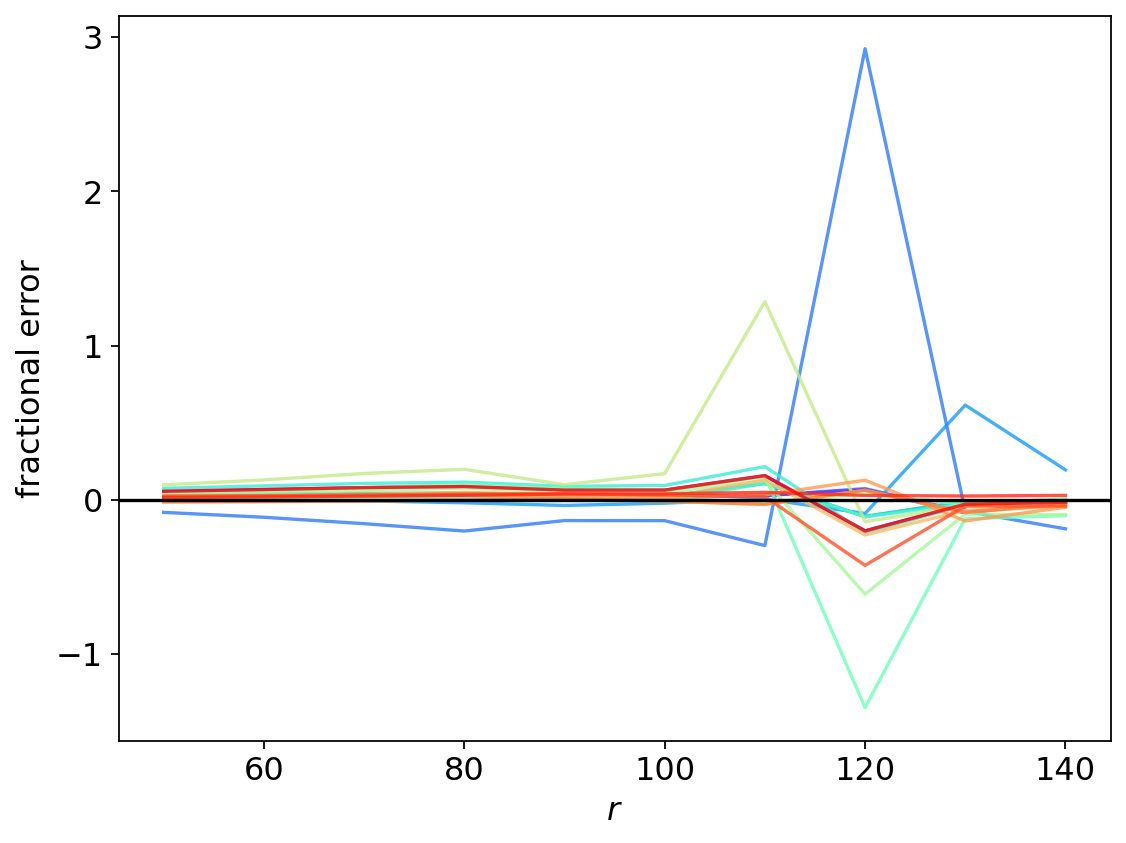

In [17]:
plt.figure(figsize=(8,6))
for i in range(n_plot):
    ys_test_plot = ys_test[idxs,:][i]
    ys_predict_plot = ys_predict[idxs][i]
    frac_err = (ys_predict_plot-ys_test_plot)/ys_test_plot
    plt.plot(r_vals, frac_err, alpha=0.8, color=colors[i])
plt.axhline(0.0, color='k')
plt.xlabel('$r$')
plt.ylabel(r'fractional error')